In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 37
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=50

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3

DATASET_DIR_NAME = "dataset\set01\\01_original"
SAMPLE_DATASET_NAME = "train"
ACTUAL_DATASET_NAME = "test"

MODEL_DIR_NAME = "dataset\set01\\01_original"
MODEL_NAME = "model_" + "set01_01_original"

RESULT_DIR_NAME = "dataset\set01\\01_original"
RESULT_NAME = "result_" + "set01_01_original"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\01_original
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\01_original
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\01_original\train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T2-RF|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-D|9
0,andy,3,mad wabble,0.155289,0.234703,0.091736,0.079413,0.142967,0.238084,0.072560,...,0.165704,0.119107,0.171939,0.040368,0.052832,0.131571,0.188983,0.075754,0.057412,0.113230
1,andy,3,bad reread,0.116150,0.285436,0.085726,0.169286,0.199709,0.248351,0.127091,...,0.076081,0.160108,0.271197,0.069895,0.111089,0.201302,0.291623,0.135957,0.090321,0.155666
2,andy,3,ink sienna,0.118185,0.273710,0.114184,0.155524,0.159526,0.248386,0.106931,...,0.196050,0.086095,0.257720,0.139502,0.171624,0.118217,0.253027,0.124216,0.134809,0.128811
3,andy,3,ion doxies,0.082255,0.330661,0.189420,0.248406,0.141242,0.283131,0.142228,...,0.124682,0.141366,0.203498,0.086235,0.062132,0.117263,0.199387,0.054129,0.082124,0.145257
4,andy,3,hey plains,0.106697,0.214285,0.117489,0.107588,0.096796,0.225085,0.090808,...,0.109095,0.125539,0.198049,0.046005,0.072510,0.152043,0.221190,0.082523,0.069147,0.138667


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


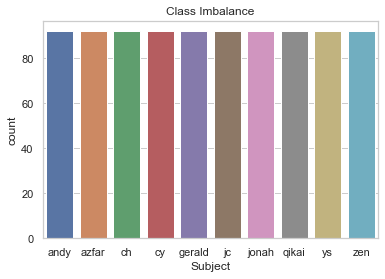

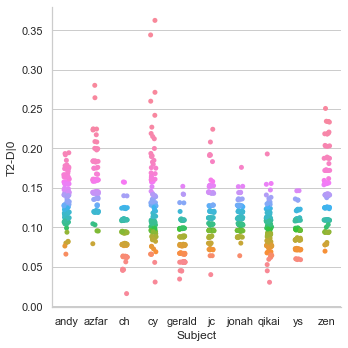

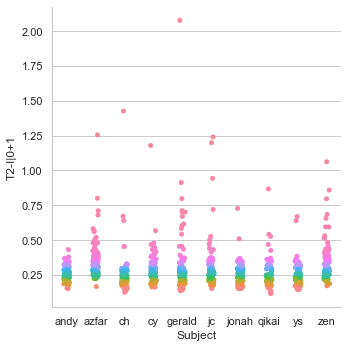

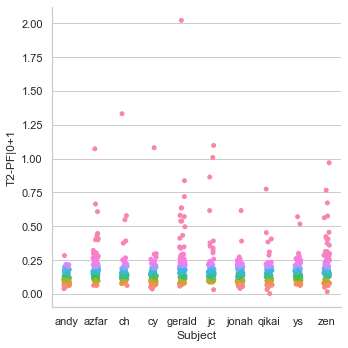

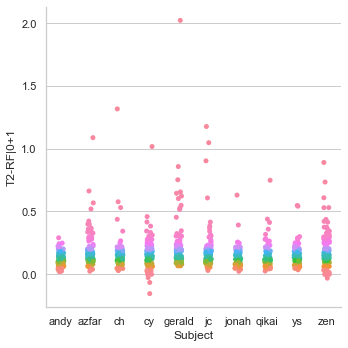

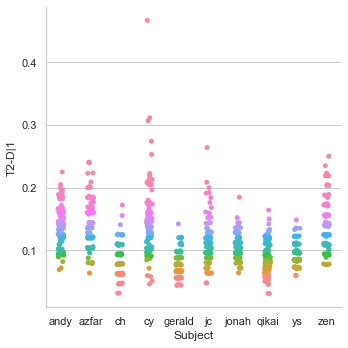

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


X | Features | Dataset Shape: (920, 37)
Y | Classes  | Dataset Shape: (920, 10)
Number of Classes: 10


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (736, 1, 37)
Y train shape: (736, 10)
X test shape: (184, 1, 37)
Y test shape: (184, 10)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 10 classes.
Epoch 1/200
12/12 [==============================] - 6s 12ms/step - loss: 2.4693 - accuracy: 0.1037
Epoch 2/200
12/12 [==============================] - 0s 11ms/step - loss: 2.4330 - accuracy: 0.0969
Epoch 3/200
12/12 [==============================] - 0s 11ms/step - loss: 2.3593 - accuracy: 0.1054
Epoch 4/200
12/12 [==============================] - 0s 12ms/step - loss: 2.3529 - accuracy: 0.0969
Epoch 5/200
12/12 [==============================] - 0s 12ms/step - loss: 2.3500 - accuracy: 0.0969
Epoch 6/200
12/12 [==============================] - 0s 12ms/step - loss: 2.3429 - accuracy: 0.1003
Epoch 7/200
12/12 [==============================] - 0s 12ms/step - loss: 2.3141 - accuracy: 0.1105
Epoch 8/200
12/12 [==============================] - 0s 12ms/step - loss: 2.3296 - accuracy: 0.1020
Epoch 9/200
12/12 [==============================] - 0s 13ms/step - loss: 2.3328 - accuracy: 0.0986
Epoch 10/200
12/12 [==============================] - 0s 13ms/step 

12/12 [==============================] - 0s 12ms/step - loss: 1.2209 - accuracy: 0.5136
Epoch 162/200
12/12 [==============================] - 0s 11ms/step - loss: 1.2575 - accuracy: 0.4728
Epoch 163/200
12/12 [==============================] - 0s 11ms/step - loss: 1.2565 - accuracy: 0.5017
Epoch 164/200
12/12 [==============================] - 0s 11ms/step - loss: 1.2259 - accuracy: 0.4932
Epoch 165/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2424 - accuracy: 0.4830
Epoch 166/200
12/12 [==============================] - 0s 11ms/step - loss: 1.2360 - accuracy: 0.4881
Epoch 167/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2349 - accuracy: 0.4745
Epoch 168/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2727 - accuracy: 0.4932
Epoch 169/200
12/12 [==============================] - 0s 11ms/step - loss: 1.3168 - accuracy: 0.4711
Epoch 170/200
12/12 [==============================] - 0s 11ms/step - loss: 1.2489 - accuracy: 0

12/12 [==============================] - 0s 12ms/step - loss: 1.3019 - accuracy: 0.5195
Epoch 122/200
12/12 [==============================] - 0s 12ms/step - loss: 1.3242 - accuracy: 0.5093
Epoch 123/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2915 - accuracy: 0.5212
Epoch 124/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2815 - accuracy: 0.5263
Epoch 125/200
12/12 [==============================] - 0s 12ms/step - loss: 1.3146 - accuracy: 0.5144
Epoch 126/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2581 - accuracy: 0.5314
Epoch 127/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2740 - accuracy: 0.5297
Epoch 128/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2720 - accuracy: 0.5331
Epoch 129/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2453 - accuracy: 0.5467
Epoch 130/200
12/12 [==============================] - 0s 12ms/step - loss: 1.3140 - accuracy: 0

12/12 [==============================] - 0s 12ms/step - loss: 1.4573 - accuracy: 0.4278
Epoch 82/200
12/12 [==============================] - 0s 12ms/step - loss: 1.4588 - accuracy: 0.4533
Epoch 83/200
12/12 [==============================] - 0s 12ms/step - loss: 1.4054 - accuracy: 0.4397
Epoch 84/200
12/12 [==============================] - 0s 12ms/step - loss: 1.4384 - accuracy: 0.4448
Epoch 85/200
12/12 [==============================] - 0s 12ms/step - loss: 1.4099 - accuracy: 0.4516
Epoch 86/200
12/12 [==============================] - 0s 13ms/step - loss: 1.3812 - accuracy: 0.4397
Epoch 87/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4058 - accuracy: 0.4567
Epoch 88/200
12/12 [==============================] - 0s 14ms/step - loss: 1.4102 - accuracy: 0.4499
Epoch 89/200
12/12 [==============================] - 0s 13ms/step - loss: 1.4185 - accuracy: 0.4584
Epoch 90/200
12/12 [==============================] - 0s 13ms/step - loss: 1.3726 - accuracy: 0.4720
Epo

12/12 [==============================] - 0s 15ms/step - loss: 1.8328 - accuracy: 0.2547
Epoch 41/200
12/12 [==============================] - 0s 14ms/step - loss: 1.8243 - accuracy: 0.2920
Epoch 42/200
12/12 [==============================] - 0s 14ms/step - loss: 1.8055 - accuracy: 0.2818
Epoch 43/200
12/12 [==============================] - 0s 14ms/step - loss: 1.7510 - accuracy: 0.2954
Epoch 44/200
12/12 [==============================] - 0s 13ms/step - loss: 1.7669 - accuracy: 0.3090
Epoch 45/200
12/12 [==============================] - 0s 13ms/step - loss: 1.8090 - accuracy: 0.2835
Epoch 46/200
12/12 [==============================] - 0s 13ms/step - loss: 1.8067 - accuracy: 0.2784
Epoch 47/200
12/12 [==============================] - 0s 13ms/step - loss: 1.7415 - accuracy: 0.3056
Epoch 48/200
12/12 [==============================] - 0s 13ms/step - loss: 1.7394 - accuracy: 0.2971
Epoch 49/200
12/12 [==============================] - 0s 14ms/step - loss: 1.6892 - accuracy: 0.3430
Epo

12/12 [==============================] - 0s 13ms/step - loss: 1.3278 - accuracy: 0.4924
Epoch 122/200
12/12 [==============================] - 0s 13ms/step - loss: 1.2696 - accuracy: 0.5229
Epoch 123/200
12/12 [==============================] - 0s 13ms/step - loss: 1.2458 - accuracy: 0.5484
Epoch 124/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2537 - accuracy: 0.5093
Epoch 125/200
12/12 [==============================] - 0s 12ms/step - loss: 1.2808 - accuracy: 0.5433
Epoch 126/200
12/12 [==============================] - 0s 13ms/step - loss: 1.2178 - accuracy: 0.5535
Epoch 127/200
12/12 [==============================] - 0s 13ms/step - loss: 1.2458 - accuracy: 0.5348
Epoch 128/200
12/12 [==============================] - 0s 13ms/step - loss: 1.2851 - accuracy: 0.5161
Epoch 129/200
12/12 [==============================] - 0s 13ms/step - loss: 1.2730 - accuracy: 0.5110
Epoch 130/200
12/12 [==============================] - 0s 13ms/step - loss: 1.2506 - accuracy: 0

12/12 [==============================] - 0s 14ms/step - loss: 1.5682 - accuracy: 0.3939
Epoch 82/200
12/12 [==============================] - 0s 14ms/step - loss: 1.5634 - accuracy: 0.4092
Epoch 83/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5964 - accuracy: 0.4126
Epoch 84/200
12/12 [==============================] - 0s 12ms/step - loss: 1.5894 - accuracy: 0.3905
Epoch 85/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5444 - accuracy: 0.3990
Epoch 86/200
12/12 [==============================] - 0s 12ms/step - loss: 1.5413 - accuracy: 0.4177
Epoch 87/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5393 - accuracy: 0.4041
Epoch 88/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5484 - accuracy: 0.4194
Epoch 89/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5314 - accuracy: 0.4024
Epoch 90/200
12/12 [==============================] - 0s 13ms/step - loss: 1.5164 - accuracy: 0.4211
Epo

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 51.49% (with standard deviation of 3.74%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 10 classes.
Epoch 1/200
15/15 [==============================] - 6s 12ms/step - loss: 2.4937 - accuracy: 0.0965
Epoch 2/200
15/15 [==============================] - 0s 11ms/step - loss: 2.3965 - accuracy: 0.0924
Epoch 3/200
15/15 [==============================] - 0s 12ms/step - loss: 2.3729 - accuracy: 0.0978
Epoch 4/200
15/15 [==============================] - 0s 12ms/step - loss: 2.3523 - accuracy: 0.1033
Epoch 5/200
15/15 [==============================] - 0s 12ms/step - loss: 2.3445 - accuracy: 0.0965
Epoch 6/200
15/15 [==============================] - 0s 13ms/step - loss: 2.3317 - accuracy: 0.1114
Epoch 7/200
15/15 [==============================] - 0s 13ms/step - loss: 2.3608 - accuracy: 0.0815
Epoch 8/200
15/15 [==============================] - 0s 17ms/step - loss: 2.3273 - accuracy: 0.1019
Epoch 9/200
15/15 [==============================] - 0s 13ms/step - loss: 2.3270 - accuracy: 0.1182
Epoch 10/200
15/15 [==============================] - 0s 13ms/step 

15/15 [==============================] - 0s 12ms/step - loss: 1.1185 - accuracy: 0.5747
Epoch 162/200
15/15 [==============================] - 0s 13ms/step - loss: 1.0578 - accuracy: 0.6223
Epoch 163/200
15/15 [==============================] - 0s 13ms/step - loss: 1.0853 - accuracy: 0.6114
Epoch 164/200
15/15 [==============================] - 0s 13ms/step - loss: 1.0380 - accuracy: 0.6046
Epoch 165/200
15/15 [==============================] - 0s 13ms/step - loss: 1.0844 - accuracy: 0.5897
Epoch 166/200
15/15 [==============================] - 0s 12ms/step - loss: 1.0481 - accuracy: 0.6073
Epoch 167/200
15/15 [==============================] - 0s 12ms/step - loss: 1.0482 - accuracy: 0.6209
Epoch 168/200
15/15 [==============================] - 0s 11ms/step - loss: 1.0372 - accuracy: 0.6141
Epoch 169/200
15/15 [==============================] - 0s 11ms/step - loss: 1.0854 - accuracy: 0.5802
Epoch 170/200
15/15 [==============================] - 0s 12ms/step - loss: 1.1300 - accuracy: 0

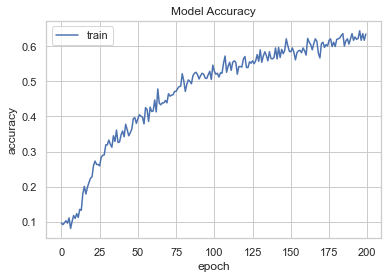

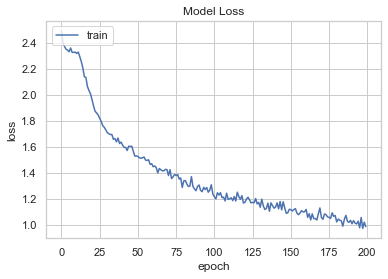

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            301056    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 49.457%


##### Confusion Matrix

184 is the number of test value in kfold_val / train_test_split


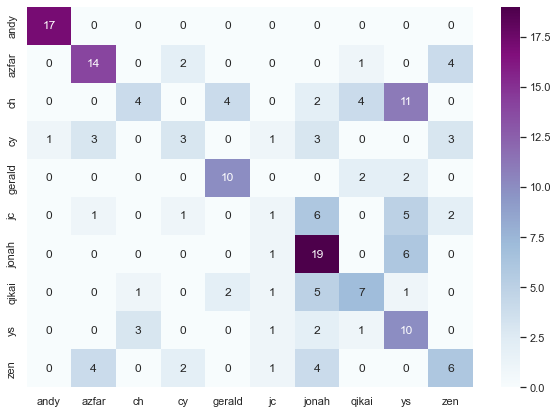

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

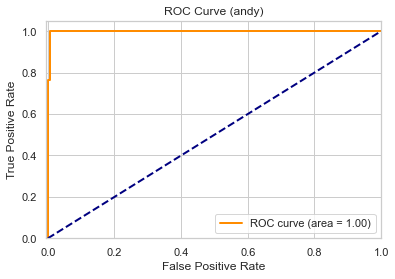

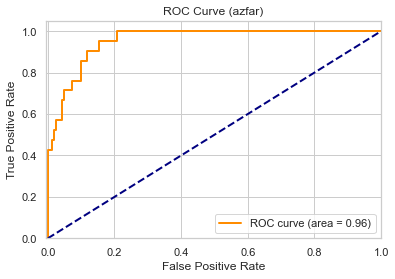

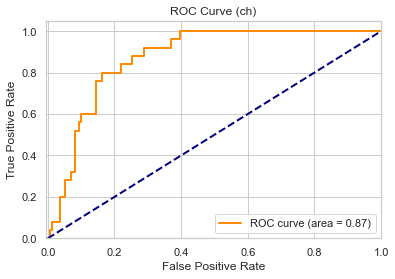

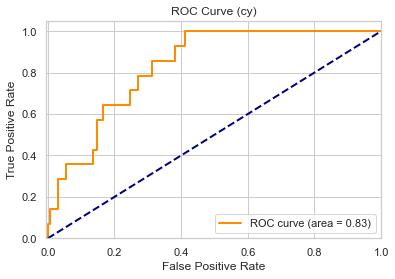

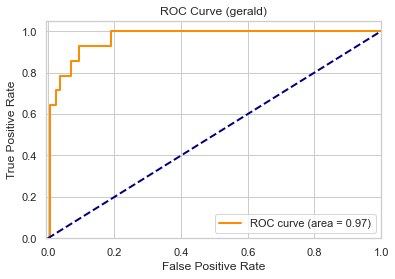

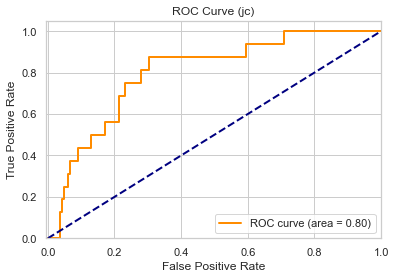

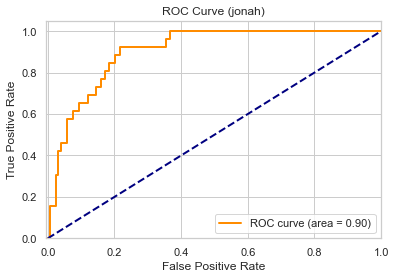

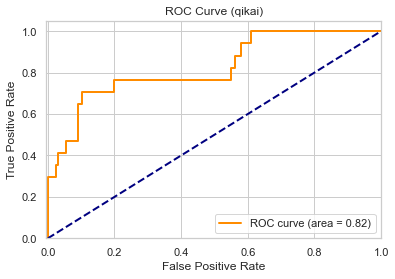

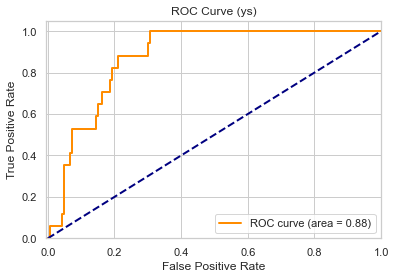

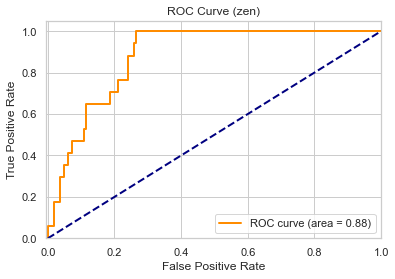

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

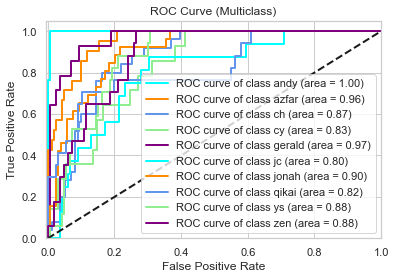

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

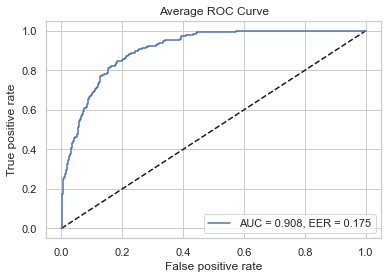

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


X | Features | Dataset Shape: (920, 37)
Y | Classes  | Dataset Shape: (920, 10)
There are a total of 10 classes.
Epoch 1/200
19/19 [==============================] - 7s 16ms/step - loss: 2.6167 - accuracy: 0.1011
Epoch 2/200
19/19 [==============================] - 0s 15ms/step - loss: 2.5046 - accuracy: 0.0946
Epoch 3/200
19/19 [==============================] - 0s 14ms/step - loss: 2.4037 - accuracy: 0.0935
Epoch 4/200
19/19 [==============================] - 0s 15ms/step - loss: 2.3754 - accuracy: 0.0967
Epoch 5/200
19/19 [==============================] - 0s 16ms/step - loss: 2.3547 - accuracy: 0.1000
Epoch 6/200
19/19 [==============================] - 0s 15ms/step - loss: 2.3539 - accuracy: 0.1022
Epoch 7/200
19/19 [==============================] - 0s 16ms/step - loss: 2.3463 - accuracy: 0.1098
Epoch 8/200
19/19 [==============================] - 0s 15ms/step - loss: 2.3394

19/19 [==============================] - 0s 14ms/step - loss: 1.3822 - accuracy: 0.4685
Epoch 81/200
19/19 [==============================] - 0s 14ms/step - loss: 1.3343 - accuracy: 0.4957
Epoch 82/200
19/19 [==============================] - 0s 16ms/step - loss: 1.3661 - accuracy: 0.4783
Epoch 83/200
19/19 [==============================] - 0s 16ms/step - loss: 1.3534 - accuracy: 0.4870
Epoch 84/200
19/19 [==============================] - 0s 14ms/step - loss: 1.3293 - accuracy: 0.4978
Epoch 85/200
19/19 [==============================] - 0s 14ms/step - loss: 1.3155 - accuracy: 0.5022
Epoch 86/200
19/19 [==============================] - 0s 15ms/step - loss: 1.3132 - accuracy: 0.5087
Epoch 87/200
19/19 [==============================] - 0s 15ms/step - loss: 1.3180 - accuracy: 0.4978
Epoch 88/200
19/19 [==============================] - 0s 15ms/step - loss: 1.3266 - accuracy: 0.4924
Epoch 89/200
19/19 [==============================] - 0s 15ms/step - loss: 1.3130 - accuracy: 0.4967
Epo

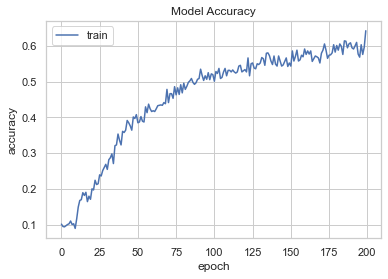

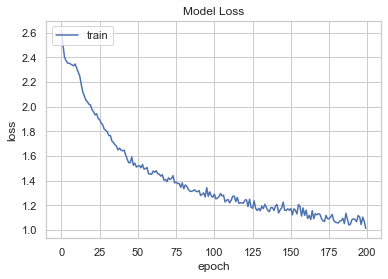

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T2-RF|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-D|9
0,andy,3,why margin,0.156546,0.305911,0.149060,0.149365,0.156852,0.276707,0.203404,...,0.211456,0.157810,0.181083,0.065032,0.023273,0.116051,0.152623,0.033008,0.036572,0.119616
1,andy,3,war encalm,0.160672,0.335976,0.110433,0.175304,0.225543,0.271715,0.103903,...,0.222109,0.189098,0.239651,0.133426,0.050553,0.106225,0.214052,0.070148,0.107827,0.143904
2,andy,4,hood whips,0.132462,0.183651,0.102099,0.051189,0.081552,0.254179,0.131667,...,0.060127,0.141966,0.191998,0.056452,0.050031,0.135546,0.240348,0.090543,0.104802,0.149805
3,andy,4,shim sweat,0.151514,0.161692,0.042774,0.010178,0.118918,0.178971,0.065487,...,0.203171,0.150809,0.246943,0.104717,0.096134,0.142226,0.237926,0.076469,0.095700,0.161457
4,andy,5,henry haji,0.128684,0.227950,0.091504,0.099266,0.136446,0.238963,0.099947,...,0.141130,0.160158,0.299132,0.167161,0.138973,0.131971,0.211203,0.059170,0.079232,0.152033


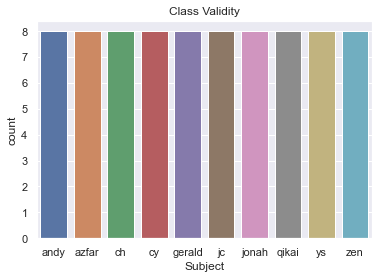

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'azfar', 'ch', 'cy', 'gerald', 'jc', 'jonah', 'qikai', 'ys', 'zen']


In [33]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model: " + str(match_header))

Accuracy of the Model: 36/80 (45.0%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:14:53
